In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Generate some SM samples

In [3]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [4]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

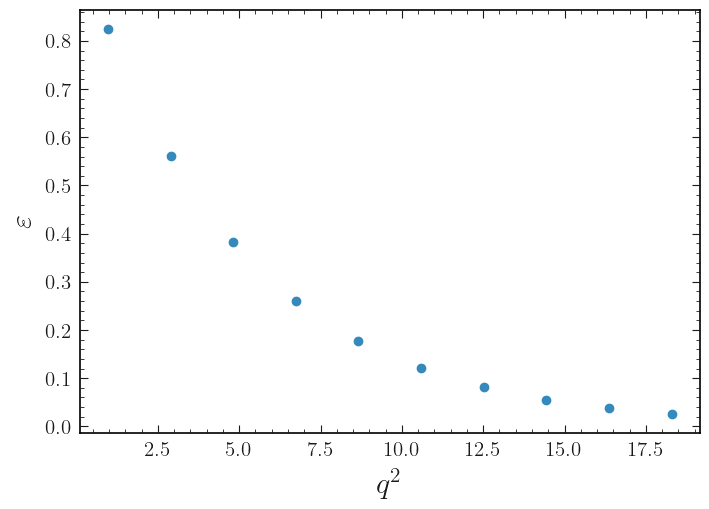

In [5]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

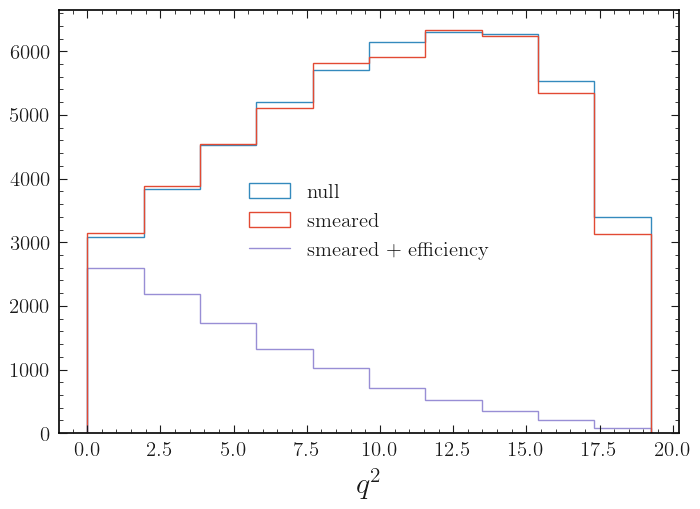

In [6]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [7]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cVR}'].set(2.0)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [8]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

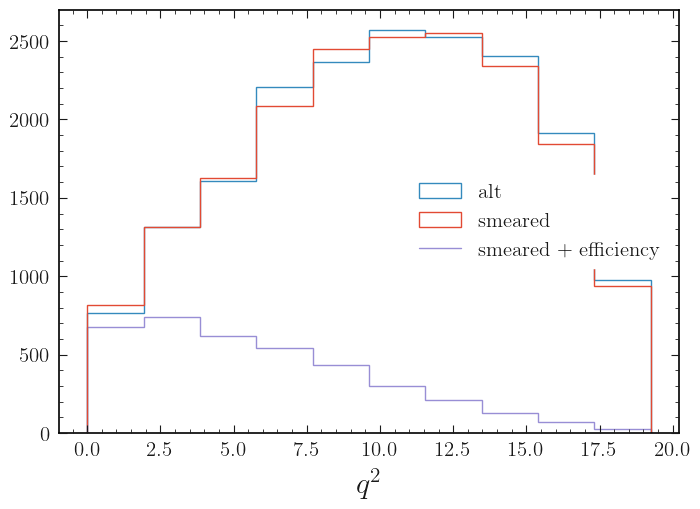

In [9]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [10]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [11]:
null = null_pred()
alt = alt_pred()

In [12]:
ana  = analysis()
cvl  = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
cvr  = ana.parameters['sbnunu::Re{cVR}'         ].evaluate()
v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()

In [13]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.001249,-0.015391,-0.149272,-0.000392,0.010801,0.102102,-0.001557,-0.009200
1,-0.015391,0.256465,1.956415,0.008476,-0.169091,-1.787828,0.162358,1.113478
2,-0.149272,1.956415,21.305733,0.045327,-1.355687,-12.006146,-0.587667,-4.252910
3,-0.000392,0.008476,0.045327,0.000561,-0.007770,-0.093994,0.015366,0.106638
4,0.010801,-0.169091,-1.355687,-0.007770,0.159369,1.644268,-0.139398,-0.956239
5,0.102102,-1.787828,-12.006146,-0.093994,1.644268,18.320518,-2.307115,-15.897721
6,-0.001557,0.162358,-0.587667,0.015366,-0.139398,-2.307115,0.872447,6.081553
7,-0.009200,1.113478,-4.252910,0.106638,-0.956239,-15.897721,6.081553,42.588645


In [14]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (v0, v1, v2, a10, a11, a12, a121, a122), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()])

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

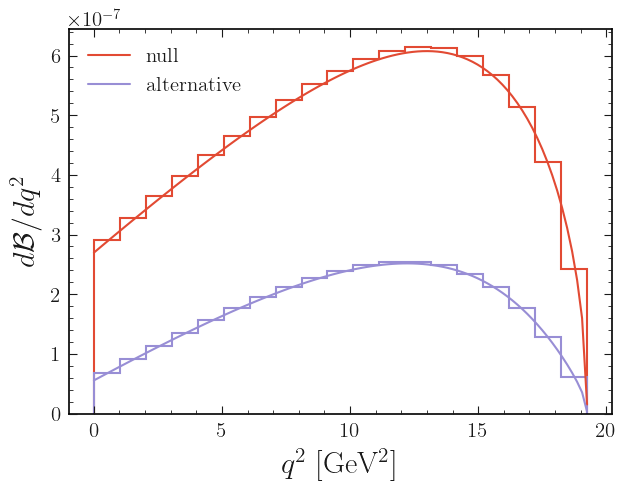

In [31]:
cvl = 5.
cvr = 2.

pars = (cvl, cvr, v0, v1, v2, a10, a11, a12, a121, a122)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

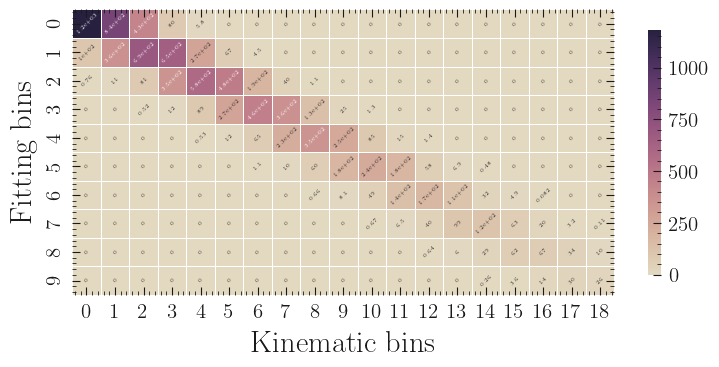

In [16]:
plot.map(cmod)

## Set up the model

In [17]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [2593.467736432129,
      2180.649970176099,
      1734.375232689232,
      1326.7342235646177,
      1028.3347907720586,
      711.8846029945881,
      518.873828874666,
      347.607924925254,
      202.5233915433896,
      80.56379518018306],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [50.92610073854201,
        46.69743001682318,
        41.64583091606208,
        36.42436304953894,
        32.0676595774007,
        26.681165697821154,
        22.778802182614122,
        18.64424642953568,
        14.231071342080666,
        8.975733684784942]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}}]}]}]}

## Save and load model

In [18]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [21]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.402976


{'cvl': array([5.11857151, 0.39860442]),
 'cvr': array([2.34687831, 0.4469241 ]),
 'FF_decorrelated[0]': array([0.09815659, 0.98547186]),
 'FF_decorrelated[1]': array([-0.2741948 ,  0.73122417]),
 'FF_decorrelated[2]': array([0.0698648 , 0.96889802]),
 'FF_decorrelated[3]': array([0.14793888, 0.95487098]),
 'FF_decorrelated[4]': array([-0.04581282,  0.98441966]),
 'FF_decorrelated[5]': array([0.00565013, 0.99285972]),
 'FF_decorrelated[6]': array([-0.03008998,  0.99113626]),
 'FF_decorrelated[7]': array([0.02377818, 0.99086921]),
 'mu': array([1., 0.]),
 'stat': [[0.9971787703456403, 0.019277762079955796],
  [1.0101470751153077, 0.019317186465364233],
  [0.9890701847629471, 0.021541695237675962],
  [1.0095459174906904, 0.024440039190133878],
  [0.988620015847118, 0.02718506435726925],
  [1.0133329207861355, 0.03273338548223648],
  [0.9853212332178154, 0.03834535791433691],
  [0.9894433645510732, 0.0474735923864999],
  [1.0160198369553086, 0.06261586734635133],
  [0.9693184133780808, 0.

In [22]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 5.1185715060884185,
 'cvr': 2.346878311470786,
 'FF[0]': 0.3724122229007387,
 'FF[1]': -1.1579711529205619,
 'FF[2]': 1.3376903872720898,
 'FF[3]': 0.2889198772331778,
 'FF[4]': 0.5119910809734066,
 'FF[5]': 1.4832736201036152,
 'FF[6]': 0.6533940982270958,
 'FF[7]': 1.5484255253182406,
 'mu': 1.0,
 'stat': [0.9971787703456403,
  1.0101470751153077,
  0.9890701847629471,
  1.0095459174906904,
  0.988620015847118,
  1.0133329207861355,
  0.9853212332178154,
  0.9894433645510732,
  1.0160198369553086,
  0.9693184133780808]}

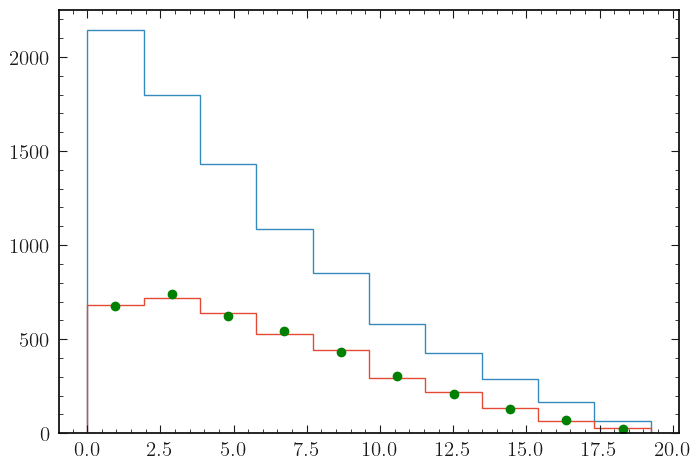

In [23]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')